In [ ]:
!pip install openturns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import openturns as ot
import openturns.viewer as otv
import numpy as np
import matplotlib.pyplot as plt
ot.Log.Show(ot.Log.NONE)

In [ ]:
distX1 = ot.Normal(1,0.1)
u12 = 11
marginals = [ot.Normal(1,0.1),ot.Normal(1,0.1),ot.Normal(1,0.1),ot.Normal(1,0.1),ot.Normal(1,0.1), ot.Uniform(u12,u12 + 1e-5)] #La dernière V.A correspond à la loi de u12
distribution = ot.ComposedDistribution(marginals)
vectorX = ot.RandomVector(distribution) #le transforme en vecteur aléatoire

### Check $u_i$ follows a uniform law

$u_i \sim \mathcal{U}([0,1])$

In [ ]:
Sample = []
for i in range(1000):
  xi = vectorX.getRealization()
  ui = [distX1.computeCDF(xi[0]), xi[1]]
  Sample.append(ui[0])
Sample = ot.Sample(np.array(Sample).reshape(-1,1))

In [ ]:
kernel = ot.KernelSmoothing()
estimated = kernel.build(Sample)

We actually estimate a uniform law.

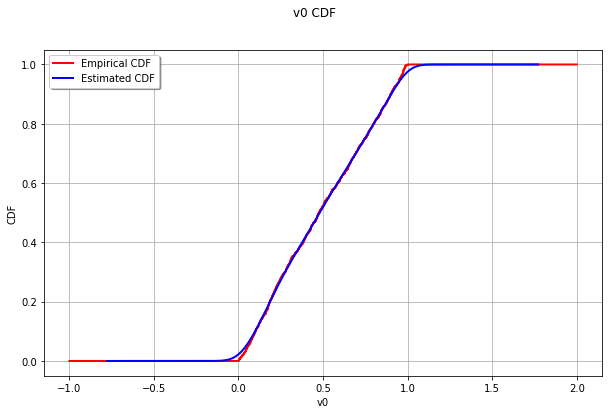

In [ ]:
fig = plt.figure(figsize=(10, 6))
xmin = Sample.getMin()[0] - 1.0
xmax = Sample.getMax()[0] + 1.0
graph = ot.UserDefined(Sample).drawCDF(xmin, xmax)
graph.setLegends(["Empirical CDF"])
graph2 = estimated.drawCDF()
graph2.setColors(["blue"])
graph2.setLegends(["Estimated CDF"])
graph.add(graph2)
view = otv.View(graph, figure = fig)

### Check $z_i$ follows a Gaussian standard law

In [ ]:
Sample2 = []
for i in range(1000):
  xi = vectorX.getRealization()
  ui = [distX1.computeCDF(xi[0]), xi[1]]
  zi = [-ot.Normal().computeInverseSurvivalFunction(ui[0])[0], ui[1]]
  Sample2.append(zi[0])
Sample2 = ot.Sample(np.array(Sample2).reshape(-1,1))

In [ ]:
kernel = ot.KernelSmoothing()
estimated = kernel.build(Sample2)

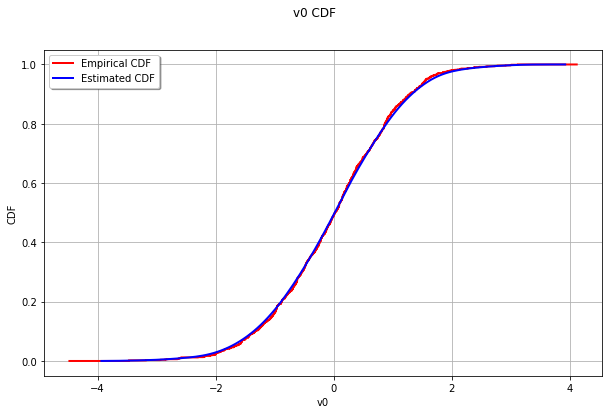

In [ ]:
fig = plt.figure(figsize=(10, 6))
xmin = Sample2.getMin()[0] - 1.0
xmax = Sample2.getMax()[0] + 1.0
graph = ot.UserDefined(Sample2).drawCDF(xmin, xmax)
graph.setLegends(["Empirical CDF"])
graph2 = estimated.drawCDF()
graph2.setColors(["blue"])
graph2.setLegends(["Estimated CDF"])
graph.add(graph2)
view = otv.View(graph, figure = fig)

## -------------------------------------------------------------------------------------------------

### Compute the probability of failure at $u_{12}$.

We have to find a value of $u_{12}$ converged. FORM is employed to compute $\mathbb{P}[U_{12}<u_{12}]$ and $\mathbb{P}[U_{12}<u_{12} + eps]$. So, we define the domain of interest as $D = \{U_{12} ∈ \mathbb{R} \backslash U_{12} < u_{12}\}$.

- ot.SymbolicFunction: Define a function
- ot.RandomVector: Create a random vector object following a given distribution.
- ot.CompositeRandomVector: Take the composition of a random vector $X$ by a function f. So it returns a CompositeRandomVector object $f(X) = (f(X_1), \cdots, f(X_n))$.
- ot.ThresholdEvent: define a rejection domain, with a threshold at $11$.

In [ ]:
formula = 'x1^2 + 2*x2 - x3 + 2*sqrt(x1*x4 + x4^2 + x5 + u12)'
f = ot.SymbolicFunction(["x1", "x2", "x3", "x4", "x5", "u12"], [formula])

vectorX = ot.RandomVector(distribution) #vecteur aléatoire
vectorY = ot.CompositeRandomVector(f, vectorX)
event = ot.ThresholdEvent(vectorY, ot.Less(), 11) #On définit le seuil comme f(x)< 11, ce qui est équivalent ici à U12 < u12

In [ ]:
solver = ot.Cobyla()
solver.setMaximumIterationNumber(10000)
solver.setMaximumAbsoluteError(1.0e-3)
solver.setMaximumRelativeError(1.0e-3)
solver.setMaximumResidualError(1.0e-3)
solver.setMaximumConstraintError(1.0e-3)

In [ ]:
algoFORM = ot.FORM(solver, event, distribution.getMean())

In [ ]:
algoFORM.run()
result = algoFORM.getResult()

In [ ]:
betaHL = result.getHasoferReliabilityIndex()
print("Hasofer index : ", betaHL)

Hasofer index :  4.275258887753417


In [ ]:
pf = ot.Normal().computeSurvivalFunction(betaHL)
print("FORM : Pf = ", pf)

FORM : Pf =  9.545765842928807e-06


In [ ]:
pf = result.getEventProbability()
print("Probability of failure (FORM) Pf = ", pf)

Probability of failure (FORM) Pf =  0.9999904542341571


### Estimate at $u_{12} + \epsilon$.

We take an arbitrary $\epsilon$

In [ ]:
eps = 0.1
u12_p = u12 + eps

We define the rejection zone.

In [ ]:
formula_p = 'x1^2 + 2*x2 - x3 + 2*sqrt(x1*x4 + x4^2 + x5 + u12 + 0.1)'
f_p = ot.SymbolicFunction(["x1", "x2", "x3", "x4", "x5", "u12"], [formula_p])
vectorY_p = ot.CompositeRandomVector(f_p, vectorX)
event_p = ot.ThresholdEvent(vectorY_p, ot.Less(), 7 + eps)

We define the inverse transform to find back the original law.

In [ ]:
solver = ot.Cobyla()
solver.setMaximumIterationNumber(10000)
solver.setMaximumAbsoluteError(1.0e-3)
solver.setMaximumRelativeError(1.0e-3)
solver.setMaximumResidualError(1.0e-3)
solver.setMaximumConstraintError(1.0e-3)

In [ ]:
algoFORM = ot.FORM(solver, event_p, distribution.getMean())

In [ ]:
algoFORM.run()
result = algoFORM.getResult()

In [ ]:
betaHL = result.getHasoferReliabilityIndex()
print("Hasofer index : ", betaHL)

Hasofer index :  8.129848474486208


In [ ]:
pf_p = ot.Normal().computeSurvivalFunction(betaHL)
print("FORM : Pf_p = ", pf_p)

FORM : Pf_p =  2.1491369216332287e-16


In [ ]:
pf_p = result.getEventProbability()
print("Probability of failure (FORM) Pf_p = ", pf_p)

Probability of failure (FORM) Pf_p =  2.1491369216332287e-16


In [ ]:
(pf_p - pf)/eps

-9.999904542341568

### Computation of the PDF

We will combine all the previous steps to compute the PDF over an interval $I$.

In [ ]:
N = 50
b_inf = 7
b_sup = 11
u12 = np.linspace(b_inf,b_sup,N)
density = np.empty(N)
CDF = np.empty(N)
i = 0
for u in u12 :
  marginals = [ot.Normal(1,0.1),ot.Normal(1,0.1),ot.Normal(1,0.1),ot.Normal(1,0.1),ot.Normal(1,0.1), ot.Uniform(u,u + 1e-5)] #La dernière V.A correspond à la loi de u12
  distribution = ot.ComposedDistribution(marginals)
  vectorX = ot.RandomVector(distribution) #vecteur aléatoire
  formula = 'x1^2 + 2*x2 - x3 + 2*sqrt(x1*x4 + x4^2 + x5 + u12)'
  f = ot.SymbolicFunction(["x1", "x2", "x3", "x4", "x5", "u12"], [formula])

  vectorY = ot.CompositeRandomVector(f, vectorX)
  event = ot.ThresholdEvent(vectorY, ot.Less(), u)

  solver = ot.Cobyla()
  solver.setMaximumIterationNumber(10000)
  solver.setMaximumAbsoluteError(1.0e-3)
  solver.setMaximumRelativeError(1.0e-3)
  solver.setMaximumResidualError(1.0e-3)
  solver.setMaximumConstraintError(1.0e-3)

  algoFORM = ot.FORM(solver, event, distribution.getMean())
  algoFORM.run()
  result = algoFORM.getResult()

  betaHL = result.getHasoferReliabilityIndex()
 # print("Hasofer index : ", betaHL)

  pf = result.getEventProbability()
#Pareil pour u12+eps
  eps = 0.1

  formula_eps = 'x1^2 + 2*x2 - x3 + 2*sqrt(x1*x4 + x4^2 + x5 + u12 + 0.1)'
  f_eps = ot.SymbolicFunction(["x1", "x2", "x3", "x4", "x5", "u12"], [formula_eps])
  vectorY_eps = ot.CompositeRandomVector(f_eps, vectorX)
  event_eps = ot.ThresholdEvent(vectorY_eps, ot.Less(), u + eps)

  algoFORM_eps = ot.FORM(solver, event_eps, distribution.getMean())

  algoFORM_eps.run()
  result_eps = algoFORM_eps.getResult()

  betaHL = result_eps.getHasoferReliabilityIndex()
  #print("Hasofer index : ", betaHL)

  pf_eps = result_eps.getEventProbability()

  density[i] = np.abs(pf_eps - pf)/eps
  CDF[i] = pf
  i+=1

In [ ]:
delta_x = (b_sup - b_inf)/N
normalisation = (b_sup - b_inf)/8*(density[0] + density[-1] + density[int(N/3)]*3 + 3*density[int(2*N/3)])
density = density/normalisation

Text(0, 0.5, 'f')

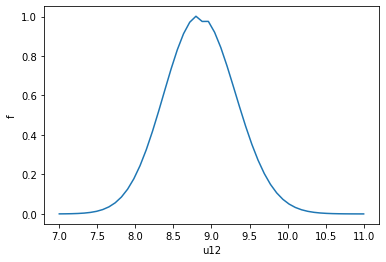

In [ ]:
density = density/normalisation

plt.plot(u12,density)
plt.xlabel("u12")
plt.ylabel("f")


Text(0, 0.5, 'CDF')

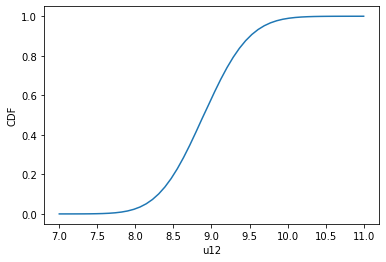

In [ ]:
plt.plot(u12,CDF)
plt.xlabel("u12")
plt.ylabel("CDF")

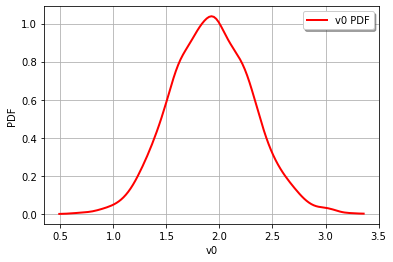

In [ ]:
Nb_sample = 5000
u12_s = []
for i in range(N):
  u12_s += [u12[i] for j in range(int(N*density[i]))]

u12_s = ot.Sample(np.array(u12_s).reshape(-1,1))
kernel = ot.KernelSmoothing()
estimated = kernel.build(u12_s)

u12_s = estimated.getSample(Nb_sample)
x1 = np.array(ot.Normal(1,0.1).getSample(Nb_sample))
x2 = np.array(ot.Normal(1,0.1).getSample(Nb_sample))
x3 = np.array(ot.Normal(1,0.1).getSample(Nb_sample))
x4 = np.array(ot.Normal(1,0.1).getSample(Nb_sample))
x5 = np.array(ot.Normal(1,0.1).getSample(Nb_sample))

u21 = x1**2 + x2 - x3 + 2*np.sqrt(np.array(u12_s))
g1 = 4.5 - (x1**2 + 2*x2 + x3 + x2*np.exp(-u21))
g2 = np.sqrt(x1) + x4 + 0.4*x1*x5
f = g2 - g1
f = ot.Sample(f)
estimated_f = kernel.build(f)

kernel_plot = estimated_f.drawPDF()
view = otv.View(kernel_plot)

# **Application to a fire detector satellite**

### Définition des variables du satellites

---



In [ ]:
def delta_t_orbit(H):
  delta_t = 2*np.pi*np.sqrt((Re + H)**3/mu)
  return delta_t

In [ ]:
def theta_slew(H):
  theta = np.arctan(np.sin(Phi_target/Re)/(1 - np.cos(Phi_target/Re) + H/Re))
  return theta

In [ ]:
def P_sa(Te,Td, P_tot):
  psa = (P_tot*Te/0.6 + P_tot*Td/0.8)/Td
  return psa

In [ ]:
w_max = 6000*2*np.pi/60 #vitesse angulaire
n = 3 #nombre de roue
P_hold = 20 #Puissance de maintien
Phi_target = 235 #target diamater
Re = 6378*1e3 #rayon de la Terre
delta_t_slew = 760 #slewing time period
mu = 3.986e14 #constante gravitationnel
Lsp = ot.Normal(2,0.4) #Moment arm for radiation torque
theta = ot.Normal(15,1) #Deviation of moment axis
As = 13.85 #Deviation of moment axis
M = 7.96e15 #Magnetic moment of Earth
Rd = ot.Normal(5,1) #Residual dipole of spacecraft
eta = 0.22 #Power efficiency
rho_sa = 700 #Average mass density to arrays
rlw = 3 #Length to width ratio of solar array
Id = 0.77 #Inherent degradation of array
eps_deg = 0.0375 #Degradation in power
LT = 15 #Lifetime of spacecraft
t = 0.005 #thickness of solar panels
rho = 5.1480e-11 #density of atmosphere
D = 2
H = ot.Normal(18e6, 1e6) #Altitude
Ha = H.getRealization()
rho_sa = 700 #Average mass density to arrays
I_body_X = 6200
I_body_Y = 6200
I_body_Z = 4700
c = 2.9979e8

### PDF de $P_{ACS}$

In marginals_P, we put in the order : $P_{\text{other}}$, $H$, $F_s$, $q$, $\theta$, $L_{sp}$, $R_D$, $L_a$, $C_d$, and the coupling variable $P_{ACS}$.

In [ ]:
N = 1000
P_ACS = np.linspace(61,80,N)

density_P = np.empty(N)
CDF_P = np.empty(N)

i = 0

for p in P_ACS:

  marginals_P = [ot.Normal(1000,50), ot.Normal(18000000,1000000), ot.Normal(1400,20), ot.Normal(0.5,1), ot.Normal(15,1), ot.Normal(2,0.4), ot.Normal(5,1), ot.Normal(2,0.4), ot.Normal(1,0.3), ot.Uniform(p,p + 1e-5)] #La dernière V.A correspond à la loi de u12
  distribution_P = ot.ComposedDistribution(marginals_P)
  vectorX_P = ot.RandomVector(distribution_P) #le transforme en vecteur aléatoire

  inputs = ['P_other','H','F_s', 'q', 'theta', 'Lsp', 'R_D', 'La', 'Cd', 'P_ACS']
  formula = 'var delta_t_orbit := 2*3.1415*sqrt((6378e3 + H)^3/3.986e14); var delta_t_eclipse := delta_t_orbit/3.1415*asin(6378*1e3/(6378*1e3 + H)); var P_tot := P_ACS + P_other;'
  formula += 'var Psa := P_tot*(delta_t_eclipse/(0.6*(delta_t_orbit - delta_t_eclipse)) + 5/4); var P_EOL := 0.22*0.77*F_s*(1 - 0.0375)^15; var Asa := Psa/P_EOL;'
  formula += 'var msa := sqrt(2*700*Asa*0.005); var L := sqrt(3*Asa/msa); var W := sqrt(Asa/(3*msa)); var IsaX := msa*(1/12*(L^2 + 0.005^2) + (2 + L/2)^2); var IsaY := msa/12*(0.005^2 + W^2);'
  formula += 'var IsaZ := msa*(1/12*(L^2 + W^2) + (2 + L/2)^2); var I_totX := IsaX + 6200; var I_totY := IsaY + 6200; var I_totZ := IsaZ + 4700; var Imax := max(I_totX,I_totY, I_totZ);'
  formula += 'var Imin := min(I_totX,I_totY, I_totZ); var theta_slew := atan(sin(235/6378*1e3)/(1 - cos(235/6378*1e3) + H/6378*1e3)); var tau_slew := 4*theta_slew/(760^2)*Imax;'
  formula += 'var tau_g := 3*3.986e14/(2*(6378e3 + H)^3)*abs(Imax - Imin)*sin(2*theta); var tau_sp := Lsp*F_s*13.85/2.9979e8*(1 + q); var tau_m := 2*7.96e15*R_D/(6378e3 + H)^3;'
  formula += 'var v := sqrt(3.986e14/(6378e3 + H)); var tau_a := 1/2*La*5.1480e-11*Cd*13.85*v^2; var tau_dist := sqrt(tau_a^2 + tau_m^2 + tau_sp^2 + tau_g^2); var tau := max(tau_slew, tau_dist);'
  formula += '628.3*tau + 20*3'

  f = ot.SymbolicFunction(inputs, [formula])
  vectorY = ot.CompositeRandomVector(f, vectorX_P)
  event = ot.ThresholdEvent(vectorY, ot.Less(), p)

  solver = ot.Cobyla()
  solver.setMaximumIterationNumber(10000)
  solver.setMaximumAbsoluteError(1.0e-3)
  solver.setMaximumRelativeError(1.0e-3)
  solver.setMaximumResidualError(1.0e-3)
  solver.setMaximumConstraintError(1.0e-3)

  algoFORM_p = ot.FORM(solver, event, distribution_P.getMean())
  algoFORM_p.run()
  result_p = algoFORM_p.getResult()

  pf_p = result_p.getEventProbability()

  #Seconde partie

  eps = 0.1

  inputs = ['P_other','H','F_s', 'q', 'theta', 'Lsp', 'R_D', 'La', 'Cd', 'P_ACS']
  formula_eps = 'var delta_t_orbit := 2*3.1415*sqrt((6378e3 + H)^3/3.986e14); var delta_t_eclipse := delta_t_orbit/3.1415*asin(6378*1e3/(6378*1e3 + H)); var P_tot := P_ACS + 0.1 + P_other;'
  formula_eps += 'var Psa := P_tot*(delta_t_eclipse/(0.6*(delta_t_orbit - delta_t_eclipse)) + 5/4); var P_EOL := 0.22*0.77*F_s*(1 - 0.0375)^15; var Asa := Psa/P_EOL;'
  formula_eps += 'var msa := sqrt(2*700*Asa*0.005); var L := sqrt(3*Asa/msa); var W := sqrt(Asa/(3*msa)); var IsaX := msa*(1/12*(L^2 + 0.005^2) + (2 + L/2)^2); var IsaY := msa/12*(0.005^2 + W^2);'
  formula_eps += 'var IsaZ := msa*(1/12*(L^2 + W^2) + (2 + L/2)^2); var I_totX := IsaX + 6200; var I_totY := IsaY + 6200; var I_totZ := IsaZ + 4700; var Imax := max(I_totX,I_totY, I_totZ);'
  formula_eps += 'var Imin := min(I_totX,I_totY, I_totZ); var theta_slew := atan(sin(235/6378*1e3)/(1 - cos(235/6378*1e3) + H/6378*1e3)); var tau_slew := 4*theta_slew/(760^2)*Imax;'
  formula_eps += 'var tau_g := 3*3.986e14/(2*(6378e3 + H)^3)*abs(Imax - Imin)*sin(2*theta); var tau_sp := Lsp*F_s*13.85/2.9979e8*(1 + q); var tau_m := 2*7.96e15*R_D/(6378e3 + H)^3;'
  formula_eps += 'var v := sqrt(3.986e14/(6378e3 + H)); var tau_a := 1/2*La*5.1480e-11*Cd*13.85*v^2; var tau_dist := sqrt(tau_a^2 + tau_m^2 + tau_sp^2 + tau_g^2); var tau := max(tau_slew, tau_dist);'
  formula_eps += '628.3*tau + 20*3'

  f_P_eps = ot.SymbolicFunction(inputs, [formula_eps])

  vectorY_p_eps = ot.CompositeRandomVector(f_P_eps, vectorX_P)
  event_p_eps = ot.ThresholdEvent(vectorY_p_eps, ot.Less(), p + eps)

  algoFORM_p_eps = ot.FORM(solver, event_p_eps, distribution_P.getMean())

  algoFORM_p_eps.run()
  result_p_eps = algoFORM_p_eps.getResult()

  betaHL = result_p_eps.getHasoferReliabilityIndex()
  #print("Hasofer index : ", betaHL)

  pf_p_eps = result_p_eps.getEventProbability()
  density_P[i] = np.abs(pf_p_eps - pf_p)/eps
  CDF_P[i] = pf_p
  i+=1

Text(0, 0.5, 'density')

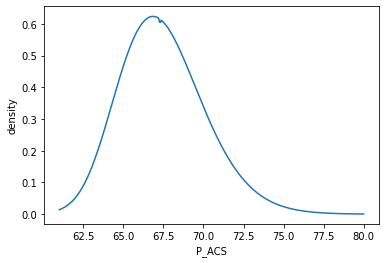

In [ ]:
normalisation_P = (b_sup - b_inf)/8*(density_P[0] + density_P[-1] + density_P[int(N/3)]*3 + 3*density_P[int(2*N/3)])
density_P = density_P/normalisation_P
plt.plot(P_ACS, density_P)
plt.xlabel("P_ACS")
plt.ylabel("density")

Text(0, 0.5, 'CDF')

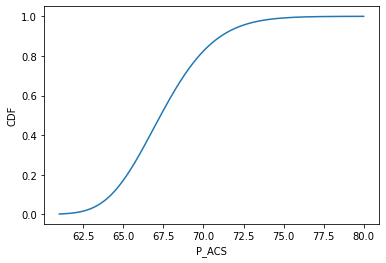

In [ ]:
plt.plot(P_ACS,CDF_P)
plt.xlabel("P_ACS")
plt.ylabel("CDF")

##PDF de $P_{tot}$

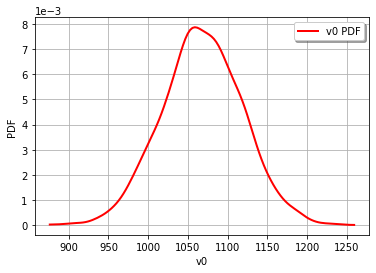

In [ ]:
Nb_sample = 5000
P_ACS_sample = []
for i in range(N):
  P_ACS_sample += [P_ACS[i] for j in range(int(N*density_P[i]))]

P_ACS_sample = ot.Sample(np.array(P_ACS_sample).reshape(-1,1))
kernel = ot.KernelSmoothing()
estimated_ACS = kernel.build(P_ACS_sample)

P_other = ot.Normal(1000,50)
P_tot = P_other.getSample(Nb_sample) + estimated_ACS.getSample(Nb_sample)
P_tot = ot.Sample(np.array(P_tot).reshape(-1,1))

estimated_tot = kernel.build(P_tot)

kernel_plot = estimated_tot.drawPDF()
view = otv.View(kernel_plot)

##PDF de $A_{sa}$

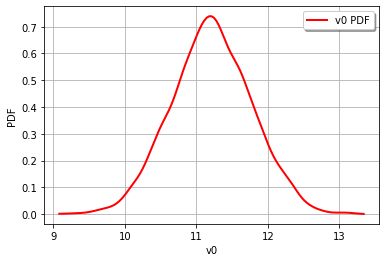

In [ ]:
Sample_P = estimated_tot.getSample(Nb_sample)

H = ot.Normal(18000000,1000000)
Fs = ot.Normal(1400,20)

Ha = H.getSample(Nb_sample)
Fsa = Fs.getSample(Nb_sample)
delta_t_orbit = 2*np.pi*np.sqrt((Re + np.array(Ha))**3/mu)

delta_t_eclipse = delta_t_orbit/np.pi*np.arcsin(Re/(Re + np.array(Ha)))

P_EOL = eta*Id*Fsa*(1 - eps_deg)**LT
P_tot = np.array(P_tot)
Psa = P_tot*(5/4 + np.array(delta_t_eclipse)/(0.6*(np.array(delta_t_orbit) - np.array(delta_t_eclipse))))

A_sa = np.array(Psa)/np.array(P_EOL)
A_sa = ot.Sample(np.array(A_sa).reshape(-1,1))

estimated_Asa = kernel.build(A_sa)

kernel_Asa = estimated_Asa.drawPDF()
view = otv.View(kernel_Asa)

##PDF de $\tau_{tot}$

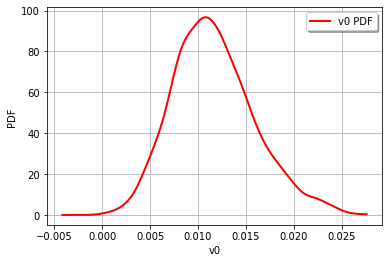

In [ ]:
A_sa_sample = np.array(estimated_Asa.getSample(Nb_sample))

H = ot.Normal(18000000,1000000)
Ha = np.array(H.getSample(Nb_sample))

Lsp = ot.Normal(2,0.4)
Lsp_s = np.array(Lsp.getSample(Nb_sample))

Fs = ot.Normal(1400,20)
Fs_s = np.array(Fs.getSample(Nb_sample))

q = ot.Normal(0.5,1)
q_s = np.array(q.getSample(Nb_sample))

theta = ot.Normal(15,1)
theta_s = np.array(theta.getSample(Nb_sample))

Cd = ot.Normal(1,0.3)
Cd_s = np.array(Cd.getSample(Nb_sample))

La = ot.Normal(2,0.4)
La_s = La.getSample(Nb_sample)

R_D = ot.Normal(5,1)
R_D_s = np.array(R_D.getSample(Nb_sample))

msa = np.sqrt(2*rho_sa*A_sa_sample*t)
L = np.sqrt(3*A_sa_sample/msa)
W = np.sqrt(A_sa_sample/(3*msa))
IsaX = msa*(1/12*(L**2 + t**2) + (D + L/2)**2)
IsaY = msa/12*(t**2 + W**2);
IsaZ = msa*(1/12*(L**2 + W**2) + (D + L/2)**2)

Ix = IsaX + I_body_X
Iy = IsaY + I_body_Y
Iz = IsaZ + I_body_Z

Imax = np.array([max(Ix[i],Iy[i],Iz[i]) for i in range(len(Ix))])
Imin = np.array([min(Ix[i],Iy[i],Iz[i]) for i in range(len(Ix))])

theta_slew = np.arctan(np.sin(Phi_target/Re)/(1 - np.cos(Phi_target/Re) + Ha/Re))
tau_slew = 4*theta_slew/(delta_t_slew)**2*Imax
tau_g = 3*mu/(2*(Re + Ha)**3)*np.abs(Imax - Imin)*np.sin(2*np.array(theta_s))
tau_sp = Lsp_s*Fs_s*As/c*(1 + q_s)
v = np.sqrt(mu/(Re + Ha))
tau_a = 1/2*La_s*rho*Cd_s*As*v**2
tau_m = 2*M*R_D_s/(Re + Ha)**3
tau_dist = np.sqrt(tau_a**2 + tau_g**2 + tau_sp**2 + tau_m**2)

tau_tot = np.array([max(tau_dist[i], tau_slew[i]) for i in range(len(tau_dist))])

tau_tot = ot.Sample(tau_tot.reshape(-1,1))

estimated_tau = kernel.build(tau_tot)

kernel_tau = estimated_tau.drawPDF()
view = otv.View(kernel_tau)

### HSIC of $P_{tot}$

In [ ]:
Nb_sample = 3000

P_other = ot.Normal(1000,50)
marginals = [P_other,estimated_ACS]
distribution = ot.ComposedDistribution(marginals)

Sample = distribution.getSample(Nb_sample)

covarianceModelCollection = []

P_other_s = Sample.getMarginal(0)
inputCovariance = ot.SquaredExponential(1)
inputCovariance.setScale(P_other_s.computeStandardDeviation())
covarianceModelCollection.append(inputCovariance)

P_ACS_s = Sample.getMarginal(1)
inputCovariance = ot.SquaredExponential(1)
inputCovariance.setScale(P_ACS_s.computeStandardDeviation())
covarianceModelCollection.append(inputCovariance)

Sample_P = np.array(P_other_s) + np.array(P_ACS_s)

Sample_P = ot.Sample(Sample_P.reshape(-1,1))

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(Sample_P.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_d_ind = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Sample, Sample_P, estimatorType)

R2HSICIndices = globHSIC_d_ind.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_d_ind.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [0.994676,0.000568602]
p-value (asymptotic):  [0,0.117146]


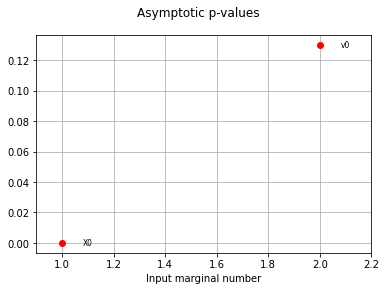

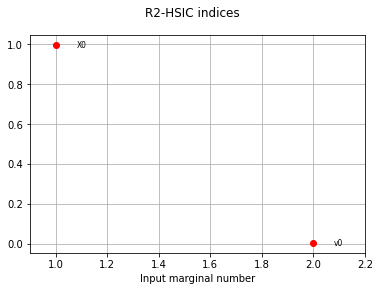

In [ ]:
graph2 = globHSIC_d_ind.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_d_ind.drawR2HSICIndices()
view3 = otv.View(graph3)